In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, AET1SensitivityMatrix

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.diagnostic import inner_product

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State



No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


In [ ]:
Tobs = YRSID_SI / 2.
dt = 5.
N = int(Tobs / dt)
Tobs = N * dt

freq = np.fft.rfftfreq(N,dt)
freq[0] = freq[1]

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False), use_gpu=False)

m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = Tobs/2 # seconds

modes = [(2,2)]

wave_freq_domain = wave_gen(m1, m2, chi1, chi2,
                            dist, phi_ref, f_ref, inc, lam,
                            beta, psi, t_ref, 
                            freqs=freq, modes=modes, 
                            direct=False, fill=True, squeeze=True, length=1024)[0]

template = wave_gen(m1*1.00001, m2, chi1, chi2,
                            dist, phi_ref, f_ref, inc, lam,
                            beta, psi, t_ref, 
                            freqs=freq, modes=modes, 
                            direct=False, fill=True, squeeze=True, length=1024)[0]

In [3]:
def wrap(*args, **kwargs):
    return wave_gen(*args, **kwargs)[0]

data = DataResidualArray(wave_freq_domain, f_arr=freq)
template = DataResidualArray(template, f_arr=freq)

sens_mat = AET1SensitivityMatrix(data.f_arr)

analysis = AnalysisContainer(data_res_arr=data, 
                             sens_mat=sens_mat, 
                             signal_gen=wrap,)   


print(analysis.template_likelihood(template))

d_d: 6618600.857962358, h_h: 6618605.279865024, d_h: (6618603.024582282+483.15209727981585j)
-0.04433140903711319


In [ ]:
#print(analysis.template_likelihood_tf(template, fs=1/dt))

-1.126688686792221e-09


/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [ ]:
from typing import Any, Tuple, Optional, List

def tf_template_snr(
        self, template: DataResidualArray, phase_maximize: bool = False, **kwargs: dict
    ) -> Tuple[float, float]:
        """Calculate the SNR of a template, both optimal and detected.

        Args:
            template: Template signal.
            phase_maximize: If ``True``, maximize over an overall phase.
            **kwargs: Keyword arguments to pass to :func:`lisatools.diagnostic.inner_product`.

        Returns:
            ``(optimal snr, detected snr)``.

        """
        kwargs_in = kwargs.copy()
        if "psd" in kwargs:
            kwargs_in.pop("psd")

        if "complex" in kwargs_in:
            kwargs_in.pop("complex")

        template_tf = sp.fft.stft(template)
        # TODO: should we cache?
        # sum of the inner product of the template divided into time segments
        sum_h_h = 0
        for i in range(len(template_tf)):
            h_h = inner_product(template_tf[i], template_tf[i], psd=self.sens_mat, **kwargs_in)
            sum_h_h += h_h
        non_marg_d_h = inner_product(
            self.data_res_arr, template, psd=self.sens_mat, complex=True, **kwargs_in
        )
        d_h = np.abs(non_marg_d_h) if phase_maximize else non_marg_d_h.copy()
        self.non_marg_d_h = non_marg_d_h

        opt_snr = np.sqrt(h_h.real)
        det_snr = d_h.real / opt_snr
        return (opt_snr, det_snr)
    

def stft_inner_product(self, A_tf, B_tf, psd, f, **kwargs):
    # loop the inner product over the time segments
    ip = 0
    #print(A_tf.shape[0], A_tf.shape)
    y_A = np.divide((A_tf[0].conj() * B_tf[0]) , np.array(AET1SensitivityMatrix(f)[0].T)[:, np.newaxis])
    y_E = np.divide((A_tf[1].conj() * B_tf[1]) , np.array(AET1SensitivityMatrix(f)[1].T)[:, np.newaxis])
    
    df = f[1] - f[0]
    # df is sunk into trapz
    tmp_out = 4 * (y_A + y_E) * df


    return np.sum(tmp_out)


def stft_inner_product_old(self, A_tf, B_tf, psd, f, **kwargs):
    # loop the inner product over the time segments
    ip = 0
    #print(A_tf.shape[0], A_tf.shape)
    for i in range(len(A_tf[0,0,:])):
        ip += inner_product(A_tf[:,:,i], B_tf[:,:,i], psd=AET1SensitivityMatrix(f), f_arr=f, **kwargs)
    return ip

def template_likelihood_tf(
    self,
    template: DataResidualArray,
    include_psd_info: bool = False,
    phase_maximize: bool = False,
    fs: float = 1.0,
    **kwargs: dict,
    ) -> float:
    """Calculate the Likelihood of a template against the data.

    Args:
        template: Template signal.
        include_psd_info: If ``True``, add the PSD term to the Likelihood value.
        phase_maximize: If ``True``, maximize over an overall phase.
        fs: Sampling frequency for the STFT.
        **kwargs: Keyword arguments to pass to :func:`lisatools.diagnostic.inner_product`.

    Returns:
        Likelihood value.

    """

    kwargs_in = kwargs.copy()
    if "psd" in kwargs_in:
        kwargs_in.pop("psd")

    if "complex" in kwargs_in:
        kwargs_in.pop("complex")

    nperseg = 50000  # Or another value tuned to your data
    wave_time_domain = np.fft.irfft(self.data_res_arr.data_res_arr, axis=-1)
    temp_time_domain = np.fft.irfft(template.data_res_arr, axis=-1)

    f_data, t_data, Z_data = sp.signal.stft(wave_time_domain, fs=fs, nperseg=nperseg*fs)
    f_temp, t_temp, Z_temp = sp.signal.stft(temp_time_domain, fs=fs, nperseg=nperseg*fs)

    d_d = self.stft_inner_product(Z_data, Z_data, psd=self.sens_mat, f=f_data, **kwargs_in)
    
    h_h = self.stft_inner_product(Z_temp, Z_temp, psd=self.sens_mat, f=f_data, **kwargs_in)

    non_marg_d_h=self.stft_inner_product(Z_data, Z_temp, psd=self.sens_mat, complex=True, f=f_data, **kwargs_in)
    d_h = np.abs(non_marg_d_h) if phase_maximize else non_marg_d_h.copy()
    
    like_out = -1 / 2 * (d_d + h_h - 2 * d_h).real
    
    #print(f"d_d: {d_d}, h_h: {h_h}, d_h: {d_h}")

    # TO DO: if include_psd_info
    #         
    return like_out


m1*1.01:        
frequency_domain_likelihood = -38795.96126595698,   
time_freq_domain_likelihood = -0.0009627886045756595

m1*1.00001:             
frequency_domain_likelihood = -0.04433140903711319,   
time_freq_domain_likelihood = -1.1266905464157873e-09

In [5]:
fs = 1/dt
nperseg = 50000
wave_time_domain = np.fft.irfft(wave_freq_domain, axis=-1)
temp_time_domain = np.fft.irfft(template.data_res_arr, axis=-1)

f_data, t_data, Z_data = sp.signal.stft(wave_time_domain, fs=fs, nperseg=nperseg*fs)
f_template, t_template, Z_template = sp.signal.stft(temp_time_domain, fs=fs, nperseg=nperseg*fs)

In [9]:
AET1SensitivityMatrix(f_data).sens_mat

array([[1.00000000e+10, 2.68178332e-40, 6.76239264e-41, ...,
        1.50545438e-38, 1.50478955e-38, 1.50411994e-38],
       [1.00000000e+10, 2.68178332e-40, 6.76239264e-41, ...,
        1.50545438e-38, 1.50478955e-38, 1.50411994e-38],
       [1.00000000e+10, 3.81657648e-50, 1.52663679e-49, ...,
        5.93596288e-39, 5.92027521e-39, 5.90459820e-39]], shape=(3, 5001))

In [125]:
ip = 0
for i in range(len(Z_data[0,0,:])):
    ip += inner_product(Z_data[:,:,i], Z_template[:,:,i], psd=AET1SensitivityMatrix(f_data), f_arr=f_data)
print(ip)

ip_original = inner_product(data, template, psd=sens_mat)

/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/opt/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


0.14009682365107942


In [126]:
print(ip, ip_original)

0.14009682365107942 6581791.603641109


In [66]:
Z_data[0,:,0].shape, f_data.shape, t_data.shape

((5001,), (5001,), (633,))

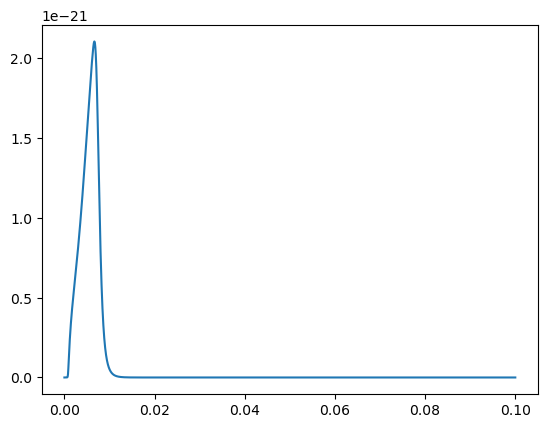

In [75]:
plt.plot(f_data, np.abs(Z_data[0,:,316]))
#plt.pcolormesh(t_data, f_data, np.abs(Z_data[0,:,:]), shading='gouraud')

ValueError: operands could not be broadcast together with shapes (5001,) (1577908,) 

In [25]:
Z_data.shape, f_data.shape, t_data.shape

((3, 5001, 633), (5001,), (633,))

In [ ]:
f, t, Z_data = sp.signal.stft(analysis.data_res_arr.data_res_arr, fs=1/dt, nperseg=50000/dt)
np.interp(f, analysis.sens_mat._frequency_arr, analysis.sens_mat._sens_mat[2])
#f, analysis.sens_mat._frequency_arr, analysis.sens_mat._sens_mat[0]


f, t, Z_data

In [42]:
analysis.sens_mat.sens_mat

array([[2.66313847e-35, 2.66313847e-35, 6.65784677e-36, ...,
        1.50412420e-38, 1.50412207e-38, 1.50411994e-38],
       [2.66313847e-35, 2.66313847e-35, 6.65784677e-36, ...,
        1.50412420e-38, 1.50412207e-38, 1.50411994e-38],
       [3.83224489e-55, 3.83224489e-55, 1.53289024e-54, ...,
        5.90469752e-39, 5.90464786e-39, 5.90459820e-39]],
      shape=(3, 1577908))

In [46]:
#sens_mat_interpolated = CubicSplineInterpolant(f, analysis.sens_mat.frequency_arr, analysis.sens_mat.sens_mat)

sens_mat_interpolated = []
for i in range(analysis.sens_mat.sens_mat.shape[0]):
    sens_mat_interpolated.append(np.interp(f, analysis.sens_mat.frequency_arr, analysis.sens_mat.sens_mat[i]))
sens_mat_interpolated

[array([2.66313847e-35, 2.68180294e-40, 6.76239949e-41, ...,
        2.66313847e-35, 2.66313847e-35, 2.66313847e-35], shape=(10000,)),
 array([2.66313847e-35, 2.68180294e-40, 6.76239949e-41, ...,
        2.66313847e-35, 2.66313847e-35, 2.66313847e-35], shape=(10000,)),
 array([3.83224489e-55, 3.81658581e-50, 1.52663731e-49, ...,
        3.83224489e-55, 3.83224489e-55, 3.83224489e-55], shape=(10000,))]

In [ ]:
f_mesh, t_mesh, template_tf = sp.signal.stft(wave_freq_domain[0], 1/dt, nperseg=50000/dt)

In [ ]:
f_mesh.shape, t_mesh.shape, template_tf.shape

In [ ]:
template.f_arr

# Likelihood Calculator in TF domain

In [ ]:
import time
import numpy as cp
def get_wave(self, parameters, include_T=False):
        if self.merger_outside:
            wave = self.wave_gen(*parameters.T, freqs=self.freq_extended_all,**self.waveform_kwargs)[0]
            start_timer = time.time()
            A_in_extended_all = cp.fft.irfft(wave[0])
            E_in_extended_all = cp.fft.irfft(wave[1])
            print('time extended', np.round(time.time() - start_timer,2))
            start_timer = time.time()
            A_in_extended_all = A_in_extended_all[:self.len_time]
            E_in_extended_all = E_in_extended_all[:self.len_time]
            print('time extended', np.round(time.time() - start_timer,2))
            start_timer = time.time()
            A_fs_extended_all = cp.fft.rfft(A_in_extended_all)[self.index_lower_cut:self.index_upper_cut]
            E_fs_extended_all = cp.fft.rfft(E_in_extended_all)[self.index_lower_cut:self.index_upper_cut]
            print('time extended fft', np.round(time.time() - start_timer,2))
            if include_T:
                T_in_extended_all = cp.fft.irfft(wave[2], n=self.len_extended_time)[:self.len_time]
                T_fs_extended_all = cp.fft.rfft(T_in_extended_all)[self.index_lower_cut:self.index_upper_cut]
                wave = np.asarray([[A_fs_extended_all, E_fs_extended_all, T_fs_extended_all]])
            else:
                wave = np.asarray([[A_fs_extended_all, E_fs_extended_all]])
        else:
            wave = self.wave_gen(*parameters.T, freqs=self.freq_new,**self.waveform_kwargs)
        return wave